# 2nd Look at the FRED Data

In [1]:
%load_ext lab_black

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import plotly.express as px
import requests
from tqdm import tqdm

from fredapi import Fred

plt.style.use("seaborn-whitegrid")
pd.set_option("max_columns", 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

## Create the FRED object

In [13]:
apifile = open("fred.api", "r")
myapi = apifile.read()
myapi = myapi.strip("\n")
fred = Fred(api_key=myapi)
apifile.close()

## What can we do with FRED?
1. Search - find things by popularity.
2. `get_series`: 

In [6]:
fred.search_by_category(33058, limit=1)

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
RIFLPBCIANM60NM,RIFLPBCIANM60NM,2022-02-08,2022-02-08,Finance Rate on Consumer Installment Loans at ...,2006-08-01,2021-11-01,Monthly,M,Percent,%,Not Seasonally Adjusted,NSA,2022-01-07 14:02:08-06:00,49,"For further information, please refer to the B..."


# Try to Figure out all the categories on FRED

In [99]:
# dfs = []
# for cat_id in tqdm(range(1000)):

#     response = requests.get(
#         f"https://api.stlouisfed.org/fred/category?category_id={cat_id}&api_key={myapi}&file_type=json"
#     )
#     if response.status_code == 400:
#         continue
#     mydf = pd.DataFrame(response.json()["categories"][0], index=[0])
#     dfs.append(mydf)

In [44]:
pd.concat(dfs).set_index("id")["parent_id"].unique()

array([    0,    10,     1, 32455, 32992, 32991,    13,    18,    24,
          22,    23,    64,    83,    15])

In [108]:
def get_cat_children(cat_id, myapi=myapi):
    try:
        response = requests.get(
            f"https://api.stlouisfed.org/fred/category/children?category_id={cat_id}&api_key={myapi}&file_type=json"
        )
        df = pd.DataFrame(response.json()["categories"]).set_index("id")
        return df
    except Exception as e:
        print(f"{cat_id} broke with exception {e}")
        return None

# Money, Banking, & Finance - Categories

In [111]:
cat_id = 32991  # # Money, Banking, & Finance
df = get_cat_children(cat_id)

ds = []
for cat_id, d in df.iterrows():
    ds.append(get_cat_children(cat_id))
df_mbf = pd.concat([df, pd.concat(ds).sort_values("id")]).reset_index().copy()

32145 broke with exception "None of ['id'] are in the columns"


In [112]:
df_mbf

,id,name,parent_id,notes
0,22,Interest Rates,32991,NaN
1,15,Exchange Rates,32991,NaN
2,24,Monetary Data,32991,NaN
3,46,Financial Indicators,32991,NaN
4,23,Banking,32991,NaN
...,...,...,...,...
66,33446,Interest Rate Spreads,22,NaN
67,33491,Saving Accounts,22,NaN
68,34003,SONIA Rates,22,NaN
69,34005,EONIA Rates,22,NaN


# Population, Employment, & Labor Markets


In [113]:
cat_id = 10  # Pop Employment
df = get_cat_children(cat_id)

ds = []
for cat_id, d in df.iterrows():
    ds.append(get_cat_children(cat_id))
df_pel = pd.concat([df, pd.concat(ds).sort_values("id")]).reset_index().copy()

32250 broke with exception "None of ['id'] are in the columns"
33500 broke with exception "None of ['id'] are in the columns"
33001 broke with exception "None of ['id'] are in the columns"
33509 broke with exception "None of ['id'] are in the columns"
33831 broke with exception "None of ['id'] are in the columns"
32240 broke with exception "None of ['id'] are in the columns"
33731 broke with exception "None of ['id'] are in the columns"


In [122]:
df_pel["is_parent"] = df_pel["id"].isin(df_pel["parent_id"].unique())

# Use Fred to Pull Population Data

In [129]:
df_pel.loc[df_pel["name"] == "Population"]["id"].values[0]

104

In [220]:
def get_cat_series(cat_id, myapi=myapi):
    response = requests.get(
        f"https://api.stlouisfed.org/fred/category/series?category_id={cat_id}&api_key={myapi}&file_type=json"
    )
    myseries = pd.DataFrame(response.json()["seriess"])
    return myseries

In [158]:
# This is all the population stuff
cat_id = 104
response = requests.get(
    f"https://api.stlouisfed.org/fred/category/series?category_id={cat_id}&api_key={myapi}&file_type=json"
)

In [163]:
pop_series = pd.DataFrame(response.json()["seriess"])

In [166]:
population = fred.get_series("B230RC0A052NBEA")

<AxesSubplot:title={'center':'Population'}>

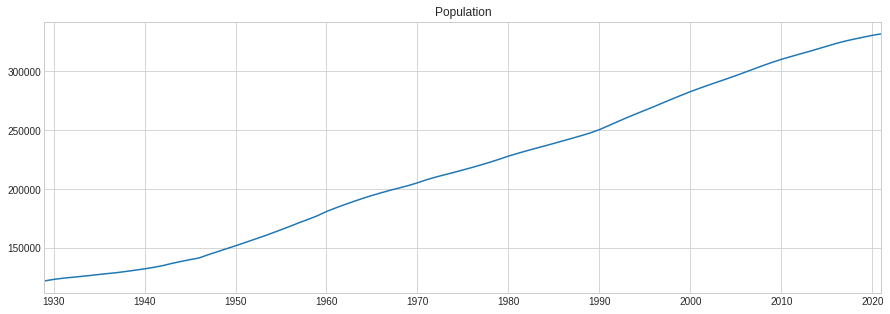

In [168]:
population.plot(figsize=(15, 5), title="Population")

# Cash $$$ Assets

In [170]:
# Pull the data
cash_assets = fred.get_series("H8B1048NCBCMG")
coc = fred.get_series("RESPPNTEPPNWW")
curr_in_circ = fred.get_series("CURRCIR")

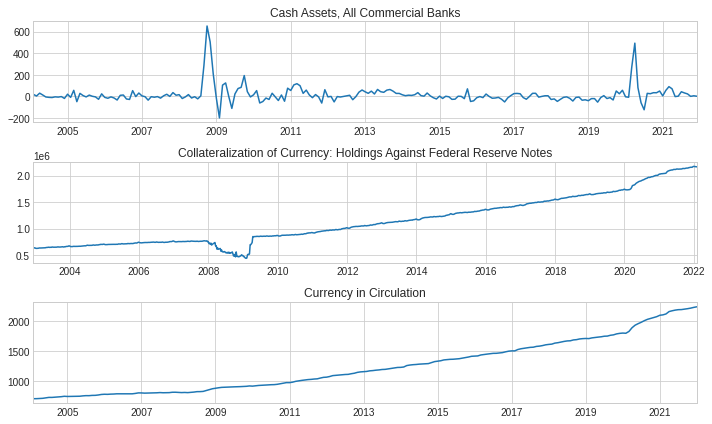

In [198]:
fig, axs = plt.subplots(3, 1, figsize=(10, 6))
cash_assets.loc[cash_assets.index > "2004"].plot(
    ax=axs[0], title="Cash Assets, All Commercial Banks"
)
coc.plot(
    ax=axs[1],
    title="Collateralization of Currency: Holdings Against Federal Reserve Notes",
)

curr_in_circ.loc[curr_in_circ.index > "2004"].plot(
    ax=axs[2], title="Currency in Circulation"
)
plt.tight_layout()
plt.show()

In [202]:
m1 = fred.get_series("M1SL")
m2 = fred.get_series("M2SL")
DGS1 = fred.get_series("DGS1")

<AxesSubplot:>

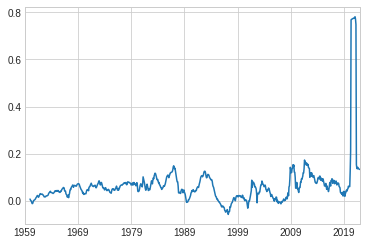

In [214]:
(m1.diff(12) / m1).plot()

<AxesSubplot:>

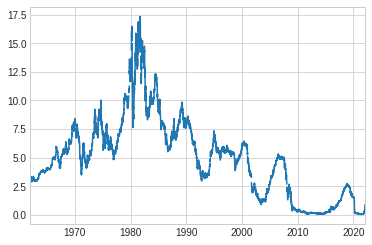

In [216]:
DGS1.plot()

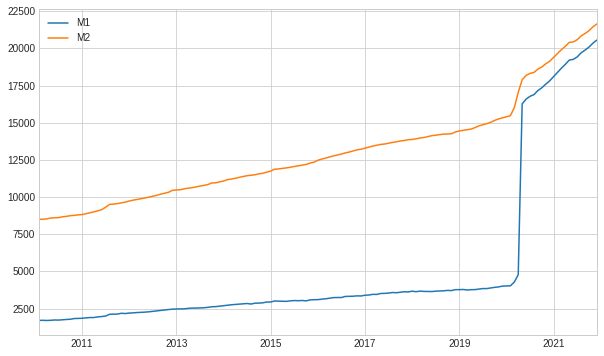

In [218]:
fig, ax = plt.subplots(figsize=(10, 6))
m1[m1.index > "2010"].plot(label="M1", ax=ax)
m2[m2.index > "2010"].plot(label="M2", ax=ax)
# ax2 = ax.twinx()
# DGS1.plot(ax=ax2)
plt.legend()
# DGS1.plot()

# Bogoodski idea:
- Pull the stock market index data 32255

In [222]:
stock_series = get_cat_series(32255)

In [229]:
dfs = []
for series_id in stock_series["id"].unique():
    myseries = fred.get_series(series_id)
    dfs.append(myseries.to_frame(series_id))

In [234]:
stonks_df = pd.concat(dfs, axis=1)

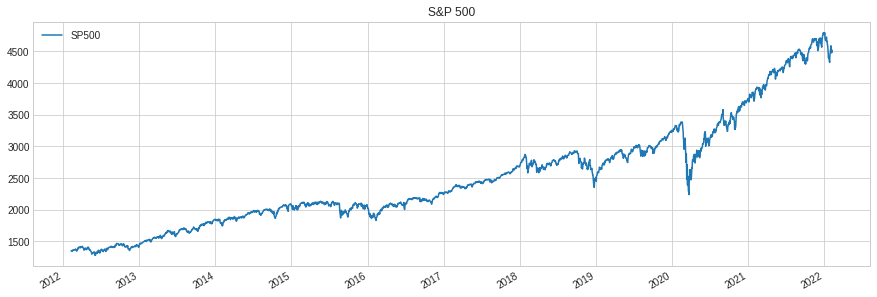

In [242]:
stonks_df["SP500"].dropna() \
    .plot(label="SP500", figsize=(15, 5), title="S&P 500")
plt.legend()
plt.show()

In [243]:
WILL5000INDFC = fred.get_series("WILL5000INDFC")

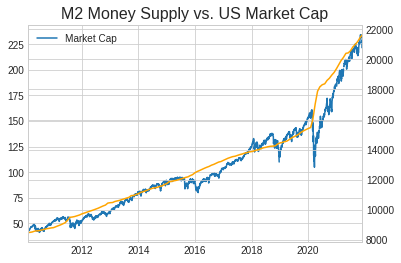

In [264]:
fig, ax = plt.subplots()
WILL5000INDFC[WILL5000INDFC.index > "2010"].plot(label="Market Cap", ax=ax)
ax2 = ax.twinx()
m2[m2.index > "2010"].plot(label="M2", ax=ax2, color="orange")
ax.legend()
ax.set_title("M2 Money Supply vs. US Market Cap", fontsize=16)
plt.show()